In [7]:
# ! pip install yfinance
# ! pip install scikit-learn
# ! pip install requests beautifulsoup4 pandas
# ! pip install lxml
# ! pip install seaborn

# ! pip install xgboost
# ! pip install torch
# ! pip install einops

Looking in indexes: https://mirrors.tencent.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
import pandas as pd
import re
from html import unescape
from io import StringIO

def fetch_fund_history(code, per=20):
    """从天天基金网抓取指定基金的历史净值数据，并合并到一个 DataFrame 中。"""
    page = 1
    all_dfs = []
    total_pages = None

    while True:
        url = f"https://fundf10.eastmoney.com/F10DataApi.aspx?type=lsjz&code={code}&page={page}&per={per}"
        response = requests.get(url, timeout=10)
        response.encoding = 'utf-8'

        # 提取 content 字段中的 HTML 表格
        match = re.search(r'content:"(.*?)",records', response.text)
        if not match:
            break
        html_str = unescape(match.group(1))
        # 通过 pandas 读取 HTML 表格
        df_list = pd.read_html(StringIO(html_str))
        if df_list:
            all_dfs.append(df_list[0])

        # 获取总页数
        if total_pages is None:
            pages_match = re.search(r'pages:(\d+)', response.text)
            if pages_match:
                total_pages = int(pages_match.group(1))
            else:
                break

        # 如果已经抓取完全部页数，则跳出循环
        if page >= total_pages:
            break
        page += 1

    if not all_dfs:
        raise ValueError("未能抓取到任何历史净值数据，请检查基金代码或网络设置。")
    return pd.concat(all_dfs, ignore_index=True)

# 抓取基金历史净值
fund_code = '007844'  # 目标基金代码
print("正在抓取基金历史数据，请稍候...")
raw_df = fetch_fund_history(fund_code)
print(f"已抓取 {len(raw_df)} 条记录。")

# 保存原始数据（可选）
raw_df.to_csv('/workspace/input/' + f'{fund_code}_history_raw.csv', index=False, encoding='utf-8-sig')
print(f"原始数据已保存至 {fund_code}_history_raw.csv")


正在抓取基金历史数据，请稍候...
已抓取 1368 条记录。
原始数据已保存至 007844_history_raw.csv


In [1]:
# 📦 基础依赖
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# 统计建模
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ML模型
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

# LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformer
from einops import rearrange


In [2]:
# 路径
file_path = '/workspace/input/007844_history_raw.csv'

# 加载
df = pd.read_csv(file_path)
df.head()


,date,unit_nav,cum_nav,daily_rate,purchase,redeem,dividend
0,2025-09-02,0.7335,0.7335,1.14%,限制大额申购,开放赎回,NaN
1,2025-09-01,0.7252,0.7252,0.06%,暂停申购,暂停赎回,NaN
2,2025-08-29,0.7248,0.7248,0.10%,限制大额申购,开放赎回,NaN
3,2025-08-28,0.7241,0.7241,0.96%,限制大额申购,开放赎回,NaN
4,2025-08-27,0.7172,0.7172,1.31%,限制大额申购,开放赎回,NaN


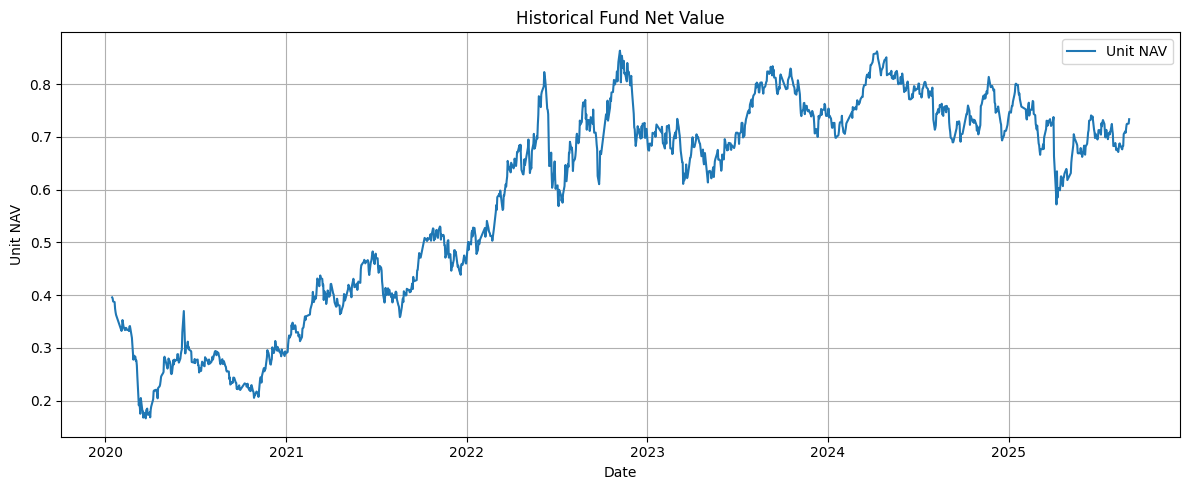

In [3]:
# 标准化列名（根据实际情况修改）
# 一般包括：日期、单位净值、累计净值、日增长率、买入状态、卖出状态
# df.columns = ['date', 'unit_nav', 'acc_nav', 'daily_growth', 'buy_status', 'sell_status']

# 保留需要的字段，并转换日期格式
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'unit_nav']].dropna().sort_values('date').reset_index(drop=True)

# 可视化数据概况
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['unit_nav'], label='Unit NAV')
plt.title("Historical Fund Net Value")
plt.xlabel("Date")
plt.ylabel("Unit NAV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# Prophet 需要特定格式：'ds' 作为日期，'y' 作为目标值
df_prophet = df.rename(columns={'date': 'ds', 'unit_nav': 'y'})


In [5]:
# 构造监督学习序列数据（用于 LSTM 和 XGBoost）
def create_supervised_data(data, window_size=30, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

# 提取目标序列
nav_series = df['unit_nav'].values

# 构造 X, y
window_size = 30
forecast_horizon = 1   # 每步预测1天，后面会循环多次递推
X, y = create_supervised_data(nav_series, window_size=window_size, forecast_horizon=forecast_horizon)

# 划分训练集和测试集
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1071, 30), y_train shape: (1071, 1)
X_test shape: (268, 30), y_test shape: (268, 1)


In [22]:
from prophet import Prophet

# 初始化 Prophet 模型
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)

# 构建未来 20 个交易日（1 个月）预测日期
future = prophet_model.make_future_dataframe(periods=20, freq='B')  # 'B' = Business Day
forecast = prophet_model.predict(future)

# 提取预测结果（未来部分）
forecast_future = forecast[forecast['ds'] > df_prophet['ds'].max()]


13:11:53 - cmdstanpy - INFO - Chain [1] start processing
13:11:53 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 设备选择（兼容 CPU/GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 自定义 Dataset
class FundDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# DataLoader
train_loader = DataLoader(FundDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(FundDataset(X_test, y_test), batch_size=32, shuffle=False)

# LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, forecast_horizon)

    def forward(self, x):  # x: (B, T, 1)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# 实例化并训练
lstm_model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# LSTM 训练
for epoch in range(100):
    lstm_model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.unsqueeze(-1).to(device), yb.to(device)
        pred = lstm_model(Xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Using device: cpu


Epoch 1, Loss: 4.0377
Epoch 2, Loss: 0.7379
Epoch 3, Loss: 0.3423
Epoch 4, Loss: 0.0730
Epoch 5, Loss: 0.0565
Epoch 6, Loss: 0.0495
Epoch 7, Loss: 0.0398
Epoch 8, Loss: 0.0396
Epoch 9, Loss: 0.0382
Epoch 10, Loss: 0.0313
Epoch 11, Loss: 0.0294
Epoch 12, Loss: 0.0255
Epoch 13, Loss: 0.0254
Epoch 14, Loss: 0.0252
Epoch 15, Loss: 0.0283
Epoch 16, Loss: 0.0256
Epoch 17, Loss: 0.0237
Epoch 18, Loss: 0.0226
Epoch 19, Loss: 0.0225
Epoch 20, Loss: 0.0219
Epoch 21, Loss: 0.0254
Epoch 22, Loss: 0.0221
Epoch 23, Loss: 0.0199
Epoch 24, Loss: 0.0227
Epoch 25, Loss: 0.0204
Epoch 26, Loss: 0.0200
Epoch 27, Loss: 0.0213
Epoch 28, Loss: 0.0200
Epoch 29, Loss: 0.0184
Epoch 30, Loss: 0.0185
Epoch 31, Loss: 0.0187
Epoch 32, Loss: 0.0173
Epoch 33, Loss: 0.0185
Epoch 34, Loss: 0.0180
Epoch 35, Loss: 0.0167
Epoch 36, Loss: 0.0172
Epoch 37, Loss: 0.0166
Epoch 38, Loss: 0.0163
Epoch 39, Loss: 0.0177
Epoch 40, Loss: 0.0158
Epoch 41, Loss: 0.0171
Epoch 42, Loss: 0.0160
Epoch 43, Loss: 0.0159
Epoch 44, Loss: 0.01

In [24]:
# 使用最近 30 天数据作为输入
input_seq = torch.tensor(nav_series[-window_size:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
lstm_preds = []

lstm_model.eval()
with torch.no_grad():
    for _ in range(20):
        pred = lstm_model(input_seq)
        next_val = pred[0, 0].item()
        lstm_preds.append(next_val)
        input_seq = torch.cat([input_seq[:, 1:, :], torch.tensor([[[next_val]]], device=device)], dim=1)


In [25]:
import xgboost as xgb

# 初始化模型
xgb_model = xgb.XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train.ravel())

# 递推预测未来 20 天
xgb_input = list(nav_series[-window_size:])  # 初始化窗口
xgb_preds = []

for _ in range(20):
    features = np.array(xgb_input[-window_size:]).reshape(1, -1)
    next_val = xgb_model.predict(features)[0]
    xgb_preds.append(next_val)
    xgb_input.append(next_val)


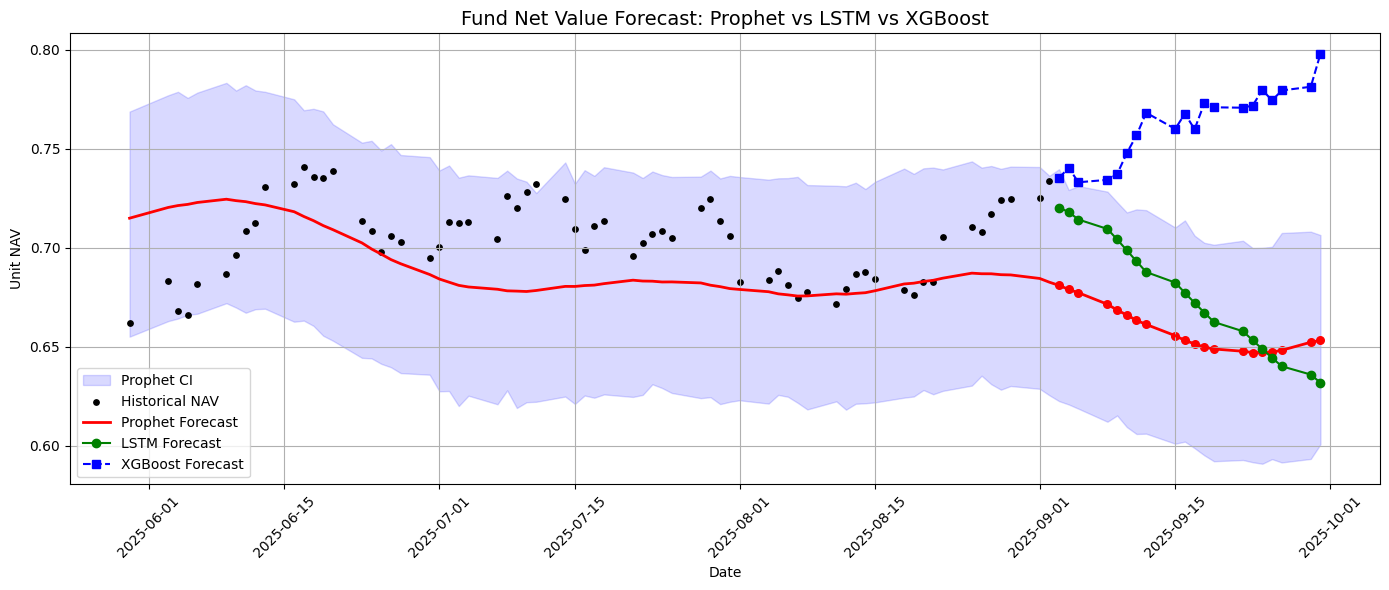

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# --------- Step 1: 设置时间窗口 ---------
end_date = forecast['ds'].max()
start_date = end_date - pd.DateOffset(months=4)  # 显示近3个月历史 + 1个月预测

# --------- Step 2: 筛选历史数据和 Prophet 结果 ---------
forecast_plot = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
history_plot = df_prophet[(df_prophet['ds'] >= start_date) & (df_prophet['ds'] <= end_date)]

# 提取 Prophet 的预测段（未来 20 天）
future_start = df_prophet['ds'].max()
forecast_future = forecast_plot[forecast_plot['ds'] > future_start]

# --------- Step 3: 构建统一的未来日期索引（用于对齐 LSTM/XGBoost） ---------
future_dates = forecast_future['ds'].reset_index(drop=True)  # Series

# --------- Step 4: 绘图 ---------
plt.figure(figsize=(14, 6))

# 🔵 Prophet置信区间
plt.fill_between(forecast_plot['ds'],
                 forecast_plot['yhat_lower'],
                 forecast_plot['yhat_upper'],
                 color='blue', alpha=0.15, label='Prophet CI')

# ⚫ 历史真实值
plt.scatter(history_plot['ds'], history_plot['y'], color='black', s=15, label='Historical NAV')

# 🔴 Prophet预测：红线 + 红点
plt.plot(forecast_plot['ds'], forecast_plot['yhat'], color='red', linewidth=2, label='Prophet Forecast')
plt.scatter(forecast_future['ds'], forecast_future['yhat'], color='red', s=30)

# 🟢 LSTM预测：绿线 + 绿点
plt.plot(future_dates, lstm_preds, color='green', linestyle='-', marker='o', label='LSTM Forecast')

# 🔷 XGBoost预测：蓝虚线 + 蓝方块点
plt.plot(future_dates, xgb_preds, color='blue', linestyle='--', marker='s', label='XGBoost Forecast')

# --------- Step 5: 图形美化 ---------
plt.title('Fund Net Value Forecast: Prophet vs LSTM vs XGBoost', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Unit NAV')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
future_df = pd.DataFrame({
    'date': future_dates,
    'prophet': forecast_future['yhat'].values,
    'lstm': lstm_preds,
    'xgboost': xgb_preds
})

print(future_df)
# future_df.to_csv('future_forecast_comparison.csv', index=False)


         date   prophet      lstm   xgboost
0  2025-09-03  0.680929  0.720249  0.735298
1  2025-09-04  0.678889  0.717991  0.740285
2  2025-09-05  0.677228  0.714207  0.733019
3  2025-09-08  0.671402  0.709438  0.734245
4  2025-09-09  0.668473  0.704148  0.737129
5  2025-09-10  0.665987  0.698649  0.747765
6  2025-09-11  0.663297  0.693125  0.756698
7  2025-09-12  0.661211  0.687678  0.768130
8  2025-09-15  0.655543  0.682355  0.759982
9  2025-09-16  0.653148  0.677171  0.767637
10 2025-09-17  0.651427  0.672129  0.759803
11 2025-09-18  0.649719  0.667220  0.772855
12 2025-09-19  0.648816  0.662436  0.770882
13 2025-09-22  0.647669  0.657767  0.770676
14 2025-09-23  0.647013  0.653205  0.771793
15 2025-09-24  0.647098  0.648743  0.779673
16 2025-09-25  0.647229  0.644375  0.774338
17 2025-09-26  0.648166  0.640094  0.779392
18 2025-09-29  0.652231  0.635895  0.781255
19 2025-09-30  0.653116  0.631775  0.797890
